In [2]:
import sksurv as sks
import sksurv.preprocessing
import sksurv.metrics
import sksurv.datasets
import sksurv.linear_model
import sksurv.ensemble

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import sklearn as skl
import scipy.stats as sp

import pymc as pm
import pymc_bart as pmb
import pandas as pd

import importlib

import mlflow as ml
import simsurv_func as ssf
import subprocess
import lifelines
import pytensor.tensor as tt
import subprocess

import pytensor.tensor as pt

# Case Cohort - Simple Bernoulli

## DTST Generator

In [686]:
np.random.seed(11)
N = 2000
x1 = np.concatenate([np.zeros(int(N*3/4)),np.ones(int(N*1/4))]) # 0,1 var (our condition)
x2 = np.random.normal(0,1, N) # continuous var
x = np.matrix([x1,x2]).T
# when x1 = 1 and x2 increases, the risk increases
z0 = -1 +2*x[:,0] + .5*x[:,1]
z0 = z0.reshape(N,1)
mu0 = sp.norm.cdf(z0).reshape(N,)

# get y
# y0 = np.random.binomial(1, p=mu0, size=N)
y0 = sp.bernoulli.rvs(p=mu0, size=N)
w = np.ones(N) # weights all 1

full = np.concatenate(
    [y0.reshape(y0.shape[0],1), 
    x,
    z0.reshape(z0.shape[0],1),
    mu0.reshape(mu0.shape[0],1)
    ], axis=1)

In [687]:
full = np.concatenate(
    [y0.reshape(y0.shape[0],1), 
    x,
    z0.reshape(z0.shape[0],1),
    mu0.reshape(mu0.shape[0],1)
    ], axis=1)

## Full Run

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Sampling: []


<xarray.DataArray 'alpha' ()>
array(-1.0225357)
[-1.10567135 -0.94026855]
[2.02092147 0.51598426]
[[1.85985623 0.44276324]
 [2.18599772 0.59346329]]


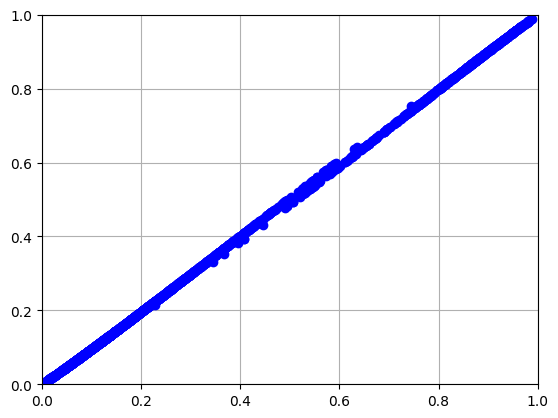

In [688]:
X = full[:,[1,2]]
Y = np.array(full[:,0]).flatten()
# W = np.array(full[:,5]).flatten()
W = np.array(np.ones(full.shape[0])).flatten()
# W = np.ones(cohrt_y.shape[0])


# custom logp
def logp_bern(value, mu, weight):
    return weight * pm.logp(pm.Bernoulli.dist(mu), value)
# extension of the bernoulli, the distribution is used as normal
def dist_bern(mu, weight, size):
    return pm.Bernoulli.dist(mu, size=size)

with pm.Model() as model1:
    x_data = pm.MutableData("x", X)
    # weights added hear
    weight = pm.MutableData("w", W)
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape = x_data.shape[1])
    z = pm.Deterministic("z", alpha + beta[0]*x_data[:,0] + beta[1]*x_data[:,1])
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    pm.CustomDist("bern", mu, weight, dist=dist_bern, logp=logp_bern, observed=Y)
    m11 = pm.sample(1000)
    
with model1:
    # weight = pm.set_data({"w":np.ones(W)})
    m11.extend(pm.sample_posterior_predictive(m11, var_names=["z","mu"]))

# Plots
z1 = m11.posterior_predictive["z"].values.mean((0,1))
mu1 = m11.posterior_predictive["mu"].values.mean((0,1))

fig, ax = plt.subplots(1)
ax.plot(full[:,4], mu1, "bo")
ax.grid(visible=True)
ax.axis(xmin=0,xmax=1,ymin=0,ymax=1)


print(m11.posterior["alpha"].mean())
print(m11.posterior["alpha"].quantile((0.025,0.975), dim=("chain", "draw")).values)
print(m11.posterior["beta"].values.mean((0,1)))
print(m11.posterior["beta"].quantile((0.025,0.975), dim=("chain","draw")).values)

Retrun of alpha and Betas are appropriate

## Create a case-cohort dtst

In [669]:
np.random.seed(10)
PRCNT = .1
PRCNT_N = int(N*PRCNT)

case_msk = np.array(full[:,0]==1).reshape(full.shape[0],)

cntrl_msk = np.random.choice(N, size=PRCNT_N, replace=False)
case = full[case_msk,:]
cntrl = full[cntrl_msk,:]

chrt = np.vstack([case,cntrl])
wt_msk = np.array(chrt[:,0]==0).flatten()
wt = np.ones(chrt.shape[0])
wt[wt_msk] = 1/PRCNT
wt = wt.reshape(wt.shape[0],1)
chrt = np.concatenate([chrt,wt],1)

### Sample with weights

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: []


<xarray.DataArray 'alpha' ()>
array(-0.91325375)
[-0.99247018 -0.82991432]
[2.0765784  0.57197204]
[[1.90761526 0.49724917]
 [2.24963404 0.64754217]]


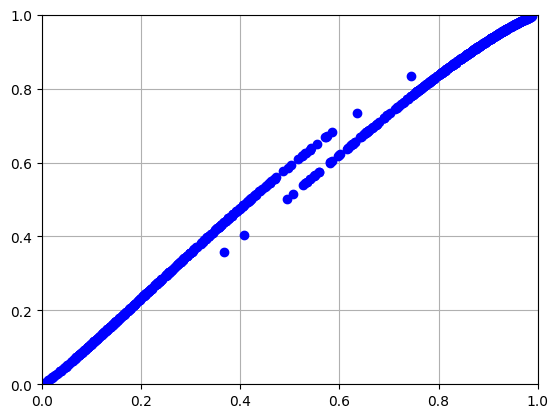

In [692]:
X = chrt[:,[1,2]]
Y = np.array(chrt[:,0]).flatten()
W = np.array(chrt[:,5]).flatten()
# W[W!=1] = W[W!=1]*1.2

# custom logp
def logp_bern(value, mu, weight):
    return weight * pm.logp(pm.Bernoulli.dist(mu), value)
# extension of the bernoulli, the distribution is used as normal
def dist_bern(mu, weight, size):
    return pm.Bernoulli.dist(mu, size=size)

with pm.Model() as model1:
    x_data = pm.MutableData("x", X)
    # weights added hear
    weight = pm.MutableData("w", W)
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape = x_data.shape[1])
    z = pm.Deterministic("z", alpha + beta[0]*x_data[:,0] + beta[1]*x_data[:,1])
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    pm.CustomDist("bern", mu, weight, dist=dist_bern, logp=logp_bern, observed=Y)
    m11 = pm.sample(1000)
    
with model1:
    weight = pm.set_data({"w":np.ones(W.shape[0])})
    m11.extend(pm.sample_posterior_predictive(m11, var_names=["z","mu"]))

z1 = m11.posterior_predictive["z"].values.mean((0,1))
mu1 = m11.posterior_predictive["mu"].values.mean((0,1))

fig, ax = plt.subplots(1)
ax.plot(chrt[:,4], mu1, "bo")
ax.grid(visible=True)
ax.axis(xmin=0,xmax=1,ymin=0,ymax=1)


print(m11.posterior["alpha"].mean())
print(m11.posterior["alpha"].quantile((0.025,0.975), dim=("chain", "draw")).values)
print(m11.posterior["beta"].values.mean((0,1)))
print(m11.posterior["beta"].quantile((0.025,0.975), dim=("chain","draw")).values)

Returns fairly good estimates, with some bias. 

The bias most likely is because of the minority ourcome (y=1) is actually overrepresented in the sample dataset

### Sample Run no weights

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: []


<xarray.DataArray 'alpha' ()>
array(0.45412142)
[0.31679218 0.5931785 ]
[1.81485447 0.57399664]
[[1.47591222 0.43780085]
 [2.15857487 0.71420558]]


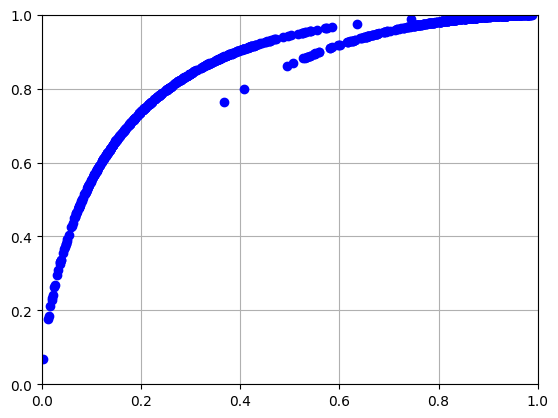

In [690]:
X = chrt[:,[1,2]]
Y = np.array(chrt[:,0]).flatten()
# W = np.array(chrt[:,5]).flatten()
# W[W!=1] = W[W!=1]*1.2
W = np.array(np.ones(chrt.shape[0])).flatten()


# custom logp
def logp_bern(value, mu, weight):
    return weight * pm.logp(pm.Bernoulli.dist(mu), value)
# extension of the bernoulli, the distribution is used as normal
def dist_bern(mu, weight, size):
    return pm.Bernoulli.dist(mu, size=size)

with pm.Model() as model1:
    x_data = pm.MutableData("x", X)
    # weights added hear
    weight = pm.MutableData("w", W)
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape = x_data.shape[1])
    z = pm.Deterministic("z", alpha + beta[0]*x_data[:,0] + beta[1]*x_data[:,1])
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    pm.CustomDist("bern", mu, weight, dist=dist_bern, logp=logp_bern, observed=Y)
    m11 = pm.sample(1000)
    
with model1:
    # weight = pm.set_data({"w":np.ones(W)})
    m11.extend(pm.sample_posterior_predictive(m11, var_names=["z","mu"]))

z1 = m11.posterior_predictive["z"].values.mean((0,1))
mu1 = m11.posterior_predictive["mu"].values.mean((0,1))

fig, ax = plt.subplots(1)
ax.plot(chrt[:,4], mu1, "bo")
ax.grid(visible=True)
ax.axis(xmin=0,xmax=1,ymin=0,ymax=1)


print(m11.posterior["alpha"].mean())
print(m11.posterior["alpha"].quantile((0.025,0.975), dim=("chain", "draw")).values)
print(m11.posterior["beta"].values.mean((0,1)))
print(m11.posterior["beta"].quantile((0.025,0.975), dim=("chain","draw")).values)

Heavily biased when the logp is not weighted. 

### Weights with a minor adjustment

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: []


<xarray.DataArray 'alpha' ()>
array(-1.01798958)
[-1.09454497 -0.94165661]
[2.08269688 0.56819127]
[[1.92600478 0.49308248]
 [2.24129273 0.64103553]]


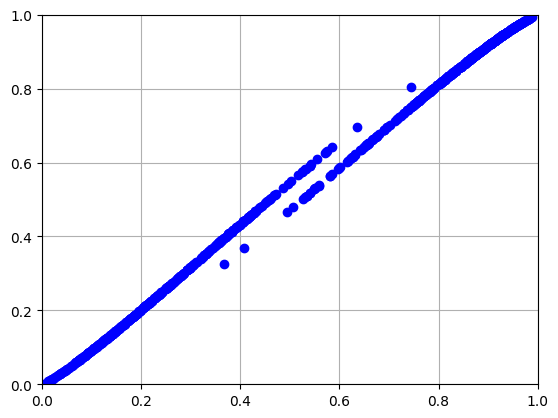

In [693]:
X = chrt[:,[1,2]]
Y = np.array(chrt[:,0]).flatten()
W = np.array(chrt[:,5]).flatten()
W[W!=1] = W[W!=1]*1.2 #################################### the 1.2 multiplier was found by trial/error

# custom logp
def logp_bern(value, mu, weight):
    return weight * pm.logp(pm.Bernoulli.dist(mu), value)
# extension of the bernoulli, the distribution is used as normal
def dist_bern(mu, weight, size):
    return pm.Bernoulli.dist(mu, size=size)

with pm.Model() as model1:
    x_data = pm.MutableData("x", X)
    # weights added hear
    weight = pm.MutableData("w", W)
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape = x_data.shape[1])
    z = pm.Deterministic("z", alpha + beta[0]*x_data[:,0] + beta[1]*x_data[:,1])
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    pm.CustomDist("bern", mu, weight, dist=dist_bern, logp=logp_bern, observed=Y)
    m11 = pm.sample(1000)
    
with model1:
    # weight = pm.set_data({"w":np.ones(W.shape[0])})
    m11.extend(pm.sample_posterior_predictive(m11, var_names=["z","mu"]))

z1 = m11.posterior_predictive["z"].values.mean((0,1))
mu1 = m11.posterior_predictive["mu"].values.mean((0,1))

fig, ax = plt.subplots(1)
ax.plot(chrt[:,4], mu1, "bo")
ax.grid(visible=True)
ax.axis(xmin=0,xmax=1,ymin=0,ymax=1)


print(m11.posterior["alpha"].mean())
print(m11.posterior["alpha"].quantile((0.025,0.975), dim=("chain", "draw")).values)
print(m11.posterior["beta"].values.mean((0,1)))
print(m11.posterior["beta"].quantile((0.025,0.975), dim=("chain","draw")).values)

Adjusting the logp weight to a slight increase returns the most accurate model. There is probably a systematic way to calculate these weights. I believe this would be in the relationship between number of Y==0 and Y==1. In this case-cohort sample the number of Y=1 is greater than Y=0 since Y=1 wasn't incredibly rare in the baseline cohort.

## Test how a random sample performs

In [704]:
smpl_msk = np.random.choice(full.shape[0], chrt.shape[0],replace=False)
smpl_chrt = full[smpl_msk,:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: []


<xarray.DataArray 'alpha' ()>
array(-1.05193174)
[-1.18540617 -0.92037202]
[2.00607267 0.54333155]
[[1.7665159  0.43323163]
 [2.2460502  0.65630471]]


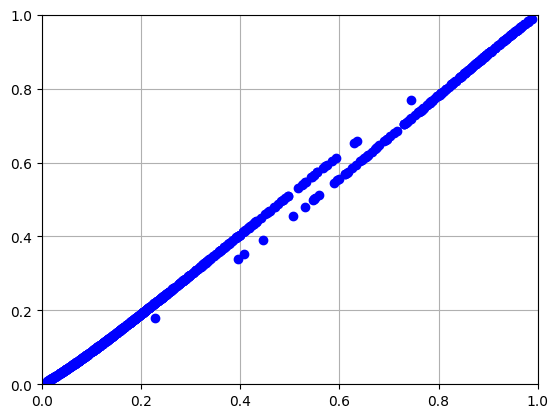

In [705]:
X = smpl_chrt[:,[1,2]]
Y = np.array(smpl_chrt[:,0]).flatten()
W = np.array(np.ones(smpl_chrt.shape[0])).flatten()


# custom logp
def logp_bern(value, mu, weight):
    return weight * pm.logp(pm.Bernoulli.dist(mu), value)
# extension of the bernoulli, the distribution is used as normal
def dist_bern(mu, weight, size):
    return pm.Bernoulli.dist(mu, size=size)

with pm.Model() as model1:
    x_data = pm.MutableData("x", X)
    # weights added hear
    weight = pm.MutableData("w", W)
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape = x_data.shape[1])
    z = pm.Deterministic("z", alpha + beta[0]*x_data[:,0] + beta[1]*x_data[:,1])
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    pm.CustomDist("bern", mu, weight, dist=dist_bern, logp=logp_bern, observed=Y)
    m11 = pm.sample(1000)
    
with model1:
    # weight = pm.set_data({"w":np.ones(W.shape[0])})
    m11.extend(pm.sample_posterior_predictive(m11, var_names=["z","mu"]))

z1 = m11.posterior_predictive["z"].values.mean((0,1))
mu1 = m11.posterior_predictive["mu"].values.mean((0,1))

fig, ax = plt.subplots(1)
ax.plot(smpl_chrt[:,4], mu1, "bo")
ax.grid(visible=True)
ax.axis(xmin=0,xmax=1,ymin=0,ymax=1)


print(m11.posterior["alpha"].mean())
print(m11.posterior["alpha"].quantile((0.025,0.975), dim=("chain", "draw")).values)
print(m11.posterior["beta"].values.mean((0,1)))
print(m11.posterior["beta"].quantile((0.025,0.975), dim=("chain","draw")).values)

The sampel cohort to the same size as the case-cohrt returns good results. However, notably the model is biased lower in the Y=1 subset. This tracks as this sample will have fewer Y=1 represented to train the model.

This model performs slightly better than the initial weighted case-cohort, but the adj. weighted case-cohort performs the best. 